# Capstone project 1: Pet Product Auto-Subcategorization by Review Analysis (modeling)

**Goal: Creating a system that automatically classifies products in Pet Supplies category into subcategories by analyzing the reviews.**  
In this project, the data collected during 2014 - 2015 in the US is used.

This jupyter notebook is about modeling. If you want to see the preprocessing, see the preprocessing jupyter notenbook.

## Recapitulation

The original data was preprocessed and divided into three; cat, dog, and other categories.  
Number of reviews per product, products, reviews, and tokens in each data:
  
| Category | Reviews/product | Total reviews | Total products | Total tokens (unique) |  
|:--------:|:---------------:|:-------------:|:--------------:|:---------------------:|  
|cat|||||
|dog|||||
|other||||||
  
  
Summary statistics of the number of tokens per product:
  
| Category |  Min  |  25%  |  50%  |  75%  |  90%  |  Max|Mean  |  SD  |  
|:--------:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|  
|cat|10|46|60|76|94|235|62.8|24.1|
|dog|||||
|other||||||

## Import packages and define functions

In [54]:
%matplotlib notebook

import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from collections import Counter
import nltk
import csv
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from sklearn.preprocessing import normalize
from sklearn.manifold import TSNE
from ipywidgets import interact

sns.set(context='notebook', style='ticks', palette='hls')
pd.set_option("display.max_colwidth", 100)

# colors
cmap1 = plt.get_cmap('tab20b') 
cmap2 = plt.get_cmap('tab20c') 

cmap1_vals = [cmap1(i) for i in range(cmap1.N)]
cmap2_vals = [cmap2(i) for i in range(cmap2.N)]

cmaps = cmap1_vals + cmap2_vals

In [2]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle the code on/off."></form>''')

In [3]:
# Define a function drewing a dendrogram
def plot_dendrogram(model, **kwargs):
    '''
    Create linkage matrix and then plot the dendrogram
    '''

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

In [4]:
# Define Silhouette analysis
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

def silhouette(n_clusters, cluster_labels, features):
    '''
    Draw Shilhouette plot 
    '''

    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(7, 7)

    # the silhouette plot
    ax1.set_xlim([-0.1, 1])
    
    # The (n_clusters+1)*10 is for inserting blank space between silhouette plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, features.shape[0] + (n_clusters + 1) * 10])

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(features, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,
                                    facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples
    
    # Average silhouette score
    silhouette_avg = np.mean(sample_silhouette_values)
    print("For n_clusters =", n_clusters, ", The average silhouette_score is :", silhouette_avg)
    
    ax1.set_title("The silhouette plot for the various clusters")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    
    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    plt.show()

In [42]:
# Define Silhouette analysis (only score)
from sklearn.metrics import silhouette_score
import matplotlib.cm as cm

def aggclus_ca_silhouette_score(min_nclus, max_nclus, interval_nclus, features):
    '''
    Do agglomerative clustering and get the Shilhouette score to various number of clusters
    '''
    n_clusters = [i for i in range(min_nclus, max_nclus+1, interval_nclus)]
    scores = []

    for k in n_clusters:
        model = AgglomerativeClustering(n_clusters=k, affinity='cosine', linkage='average')
        model = model.fit(features)
        
        score = silhouette_score(features, model.labels_)
        scores.append(round(score, 4))
    
    return n_clusters, scores

In [7]:
def frequent_words(df, label_column):
    '''
    Find the most frequent 10 words in each cluster
    '''
    n_clusters = df[label_column].nunique()
    df_cluster = pd.DataFrame(columns=['cluster number','frequent words', 'number of products'])
    for i in range(n_clusters):
        words = []
        indexes = df[df[label_column] == i].index
        for index in indexes:
            for word in set(new_cat_token_list[index]):
                words.append(word)
        c = Counter(words)
        values, _ = zip(*c.most_common(10))

        df_temp = pd.DataFrame([[i, values, len(indexes)]], 
                                columns=['cluster number','frequent words', 'number of products'])
        df_cluster = df_cluster.append(df_temp) # ignore_index=True

    return df_cluster.set_index('cluster number')

In [141]:
# Scatter plot, coloring by variety_numbers
def cluster_plot(tsne_features, cluster_n, df, cluster_n_column, label_column):
    '''
    Plot the t-SNE image for a big_category cluster with the selected labels
    '''
    plt.figure(figsize=(9,7))

    df_cluster = df[df[cluster_n_column] == cluster_n].sort_index()

    for i in df_cluster[label_column].unique():
        bool_array = (df_cluster[label_column] == i).values
        plt.scatter(tsne_features[cluster_n][bool_array][:,0], 
                    tsne_features[cluster_n][bool_array][:,1], 
                    s=4, alpha=0.8, c=[cmap1(i/df_cluster[label_column].nunique())], label=i)   
        plt.text(tsne_features[cluster_n][bool_array][:,0][0],
                 tsne_features[cluster_n][bool_array][:,1][0],
                 str(i), color="black", size=16)

## 4. Building the model

#### Approach:

4.1. Dog category  
4.1.1. Load data  
4.1.2. Vectorization with tf-idf  
4.1.3. Dimensional reduction  
4.1.4. Applying k-means model

4.2. Cat category  
4.2.1. Load data  
4.2.2. Vectorization with tf-idf  
4.3.3. Dimensional reduction  
4.4.4. Applying k-means model

### 4.2. Cat category

#### 4.2.1. Load data

In [8]:
# Load the token list
cat_token_list = []
with open("cat_token_list_10_4.csv", "r", encoding="UTF-8") as f:
    reader = csv.reader(f) 
    for r in reader: 
        cat_token_list.append(r)
        
len(cat_token_list), cat_token_list[:2]

(3935,
 [['templat',
   'wont',
   'door',
   'pick',
   'litter',
   'box',
   'door',
   'cat',
   'adjust',
   'medium',
   'medium',
   'mistak',
   'opinion',
   'design',
   'cat',
   'bedroom',
   'cat',
   'reluct',
   'flap',
   'snap',
   'bar',
   'magnet',
   'cool',
   'air',
   'cat',
   'hole',
   'measur',
   'aw',
   'instruct',
   'lucki',
   'ruin',
   'door',
   'instal'],
  ['cat',
   'dishwash',
   'top',
   'shelf',
   'snap',
   'natur',
   'balanc',
   'oz',
   'cat',
   'food',
   'awesom',
   'servic',
   'cat',
   'food',
   'dishwash',
   'accid',
   'shrunk',
   'pay',
   'fit',
   'dishwash',
   'warp',
   'shrink',
   'dog',
   'food',
   'fit',
   'amaz',
   'color',
   'style',
   'fit',
   'wet',
   'food',
   'dishwash',
   'plenti',
   'compar',
   'groceri',
   'set',
   'complaint']])

In [9]:
cat_tokens = ['cat', 'kitti', 'kitten']

In [10]:
new_cat_token_list = []

for product in cat_token_list:
    nested_list = []
    for token in product:
        if token not in cat_tokens:
            nested_list.append(token)
    new_cat_token_list.append(nested_list)

In [11]:
len(new_cat_token_list)

3935

In [12]:
# How many unique words?
len(set(token for review in new_cat_token_list for token in review))

5840

In [13]:
# Load the product table
df_cat_id_name = pd.read_csv("df_cat_id_name_10_4.csv")
df_cat_id_name

,product_id,product_title
0,70064,Perfect Pet Soft Flap Cat Door with Telescoping FramePerfect Pet Soft Flap Cat Door with Telesco...
1,593896,Pet Food Can Covers Lids Set of 3Pet Food Can Covers Lids Set of 3Pet Food Can Covers Lids Set o...
2,919291,Basis Pet Made in the USA Low Profile Stainless Steel Cat DishBasis Pet Made in the USA Low Prof...
3,944764,Alfie Pet by Petoga Couture - Vea 2.0 Slow-Eating Anti-Gulping Pet Food Bowl (for Dogs & Cats)Al...
4,1124833,Petmate Hooded Cat Litter PanPetmate Hooded Cat Litter PanPetmate Hooded Cat Litter PanPetmate H...
...,...,...
3930,999135471,NaturVet Naturals Dog & Cat Allergy Aid Soft ChewsNvet Aller-911 Sft Chew 90ctNaturVet Naturals ...
3931,999281618,Nature's Variety Pride by Instinct Grain Free Dry Cat FoodNature's Variety Pride by Instinct Gra...
3932,999404580,Purina Friskies Party Mix Naturals Cat Treats - 10-2.1 oz. PouchesPurina Friskies Party Mix Natu...
3933,999408900,Wicker Cat Litter Pan CoverWicker Cat Litter Pan CoverWicker Cat Litter Pan CoverWicker Cat Litt...


#### 4.2.1. Vectorization with tf-idf

**count vectorizer**

2grams, all dimensions

In [17]:
# Generate matrix of word vectors

# Create CountVectorizer object 
def dummy_tokened(text):
    return text

# Remove less frequent words
cvectorizer_cat = CountVectorizer(tokenizer=dummy_tokened,lowercase=False, min_df=6, 
                                     ngram_range=(1, 2))

bow_cat = cvectorizer_cat.fit_transform(new_cat_token_list)

# Get the feature names
feature_names_cat = cvectorizer_cat.get_feature_names()

# Show the shape of tfidf_matrix
bow_cat.shape

(3935, 4949)

In [18]:
normalized_bow_cat = normalize(bow_cat)

In [20]:
# Create a TSNE instance
tsne_cat = TSNE(perplexity=50, learning_rate=800, random_state=10)

# Apply fit_transform to samples
tsne_features_cat = tsne_cat.fit_transform(normalized_bow_cat)

<IPython.core.display.Javascript object>


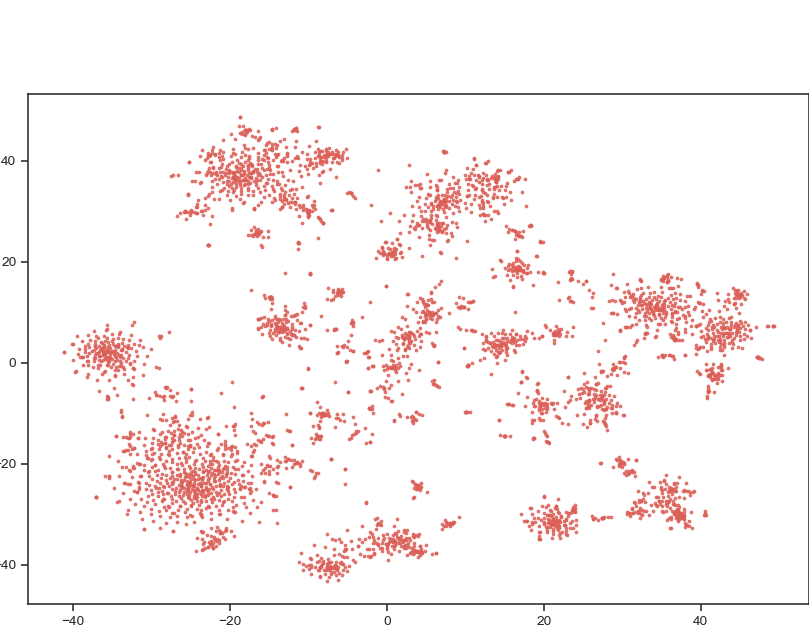

In [21]:
# Scatter plot, coloring by variety_numbers
plt.figure(figsize=(9,7))
tsne_features = tsne_features_cat

plt.scatter(tsne_features[:,0], tsne_features[:,1], s=4, alpha=0.8)   
        
plt.subplots_adjust(left=0.035, right=0.999, bottom=0.04, top=0.85)
plt.show()

In [22]:
np_normalized_bow_cat = normalized_bow_cat.toarray()

Hierarchical clustering

cosine, average

In [24]:
# setting distance_threshold=0 ensures we compute the full tree.
model_cat = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity='cosine', linkage='average')
model_cat = model_cat.fit(np_normalized_bow_cat)

<IPython.core.display.Javascript object>


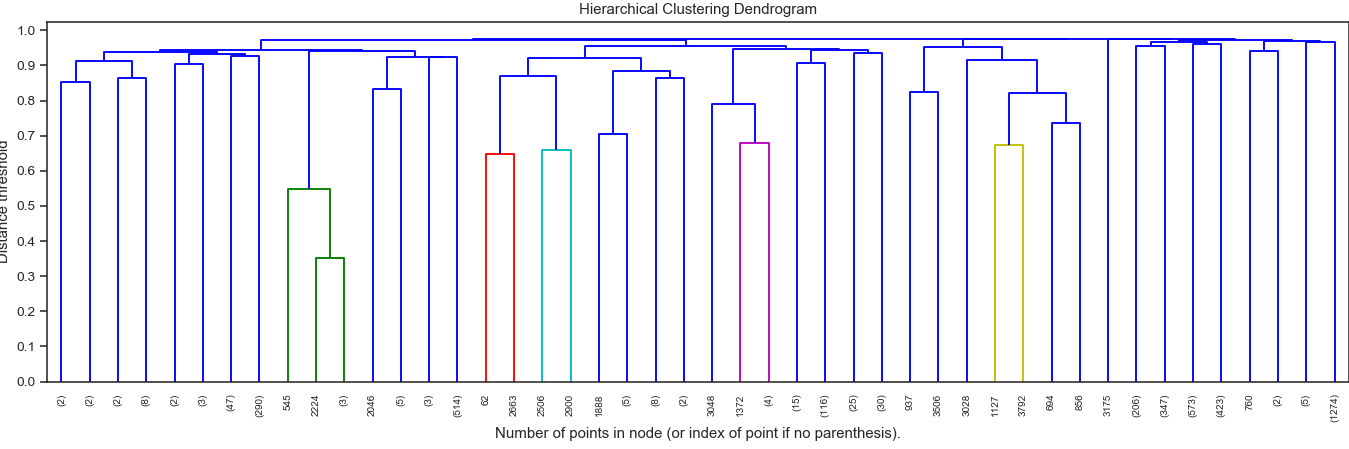

In [25]:
plt.figure(figsize=(15,5))
plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
plot_dendrogram(model_cat, truncate_mode='level', p=5)

plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.subplots_adjust(left=0.035, right=0.999, bottom=0.15, top=0.95)
plt.ylabel("Distance threshold")
plt.yticks([i/10 for i in range(0,11,1)])
plt.show()

remove outliers

In [27]:
# setting distance_threshold=0 ensures we compute the full tree.
model_cat_out = AgglomerativeClustering(distance_threshold=0.95, n_clusters=None, affinity='cosine', linkage='average')
model_cat_out = model_cat_out.fit(np_normalized_bow_cat)

<IPython.core.display.Javascript object>


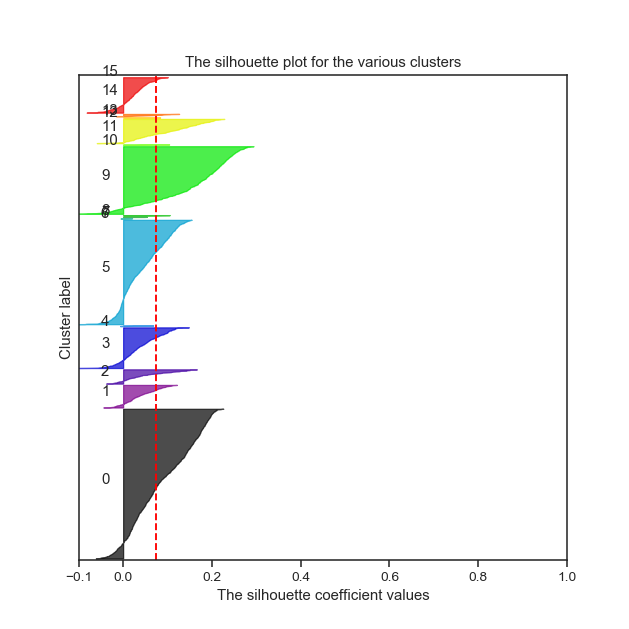

For n_clusters = 16 , The average silhouette_score is : 0.07505822934436818


In [43]:
silhouette(model_cat_out.n_clusters_, model_cat_out.labels_, np_normalized_bow_cat)

In [29]:
# the number of products in each cluster
for i in range(model_cat_out.n_clusters_):
    print(i, ':', len(np.where(model_cat_out.labels_ == i)[0]))

0 : 1268
1 : 192
2 : 122
3 : 345
4 : 6
5 : 884
6 : 3
7 : 2
8 : 5
9 : 573
10 : 5
11 : 206
12 : 2
13 : 20
14 : 301
15 : 1


In [30]:
df_label_cat_out = df_cat_id_name[['product_id', 'product_title']]
df_label_cat_out['label'] = model_cat_out.labels_

In [31]:
other_clusters = [4, 6, 7, 8, 10, 12, 15]
df_other = pd.DataFrame()

for i in other_clusters:
    df_other = df_other.append(df_label_cat_out[df_label_cat_out['label'] == i])

print(len(df_other))
df_other

24


,product_id,product_title,label
89,19102244,"Nutri-Vet Feline Paw Gel, 3-ouncesNutri-Vet Feline Paw Gel, 3-ouncesNutri-Vet Feline Paw Gel, 3-...",4
473,126733564,Wee Cleaner - Pet Urine Odor Remover for Cat and Dog Urine (1-gallon bottle)Wee Cleaner - Pet Ur...,4
1505,377349050,Hartz Precision Nutrition Adult Cat Multi Vitamins with PrebioticsHartz Precision Nutrition Adul...,4
1532,384301678,Reptaid - 1 fl oz.- An herbal Supplement to help your small reptiles overcome some parasitic and...,4
2041,521996119,"Zilla Reptile Health Supplies Jump-Start Appetite Stimulant, 4.25-oz.Zilla Reptile Health Suppli...",4
2995,771545768,Cat Vitamins - Spectrin 16 OZ - Liquid Vitamin & Antioxidant Supplement for Cats - 96 dosesCat V...,4
760,192390369,The Cat in the HatThe Cat in the HatThe Cat in the HatThe Cat in the HatThe Cat in the HatThe Ca...,6
2245,576700393,"Aspen Pet Puffy Round Cat Bed (18"") Assorted ColorsAspen Pet Puffy Round Cat Bed (18"") Assorted ...",6
3644,928910893,"NaturVet Joint Support Gel for Cats, 3 oz Gel, Made in USANaturVet Joint Support Gel for Cats, 3...",6
937,237546267,"Safe Waterproof Heated Bed Pad For Dog Cat Pet, 15WSafe Waterproof Heated Bed Pad For Dog Cat Pe...",7


In [32]:
# Get the normalized bow matrix of cluster 2, 13, and 41
df_cat_id_name_removed = pd.DataFrame()

for i in range(len(df_cat_id_name)):
    if i not in df_other.index:
        df_cat_id_name_removed = df_cat_id_name_removed.append(df_cat_id_name.iloc[i])

len(df_cat_id_name_removed)

3911

In [33]:
# Get the normalized bow matrix of cluster 2, 13, and 41
np_normalized_bow_cat_removed = np.array([np_normalized_bow_cat[i] 
                                          for i in range(len(np_normalized_bow_cat)) if i not in df_other.index])
len(np_normalized_bow_cat_removed)

3911

In [34]:
# Get the t-SNE features of cluster 2, 13, and 41
tsne_features_cat_removed = np.array([tsne_features_cat[i] 
                                      for i in range(len(tsne_features_cat))if i not in df_other.index])
len(tsne_features_cat_removed)

3911

In [44]:
rough_n_k_cat, rough_scores_cat  = aggclus_ca_silhouette_score(5, 120, 5, np_normalized_bow_cat_removed)

<IPython.core.display.Javascript object>


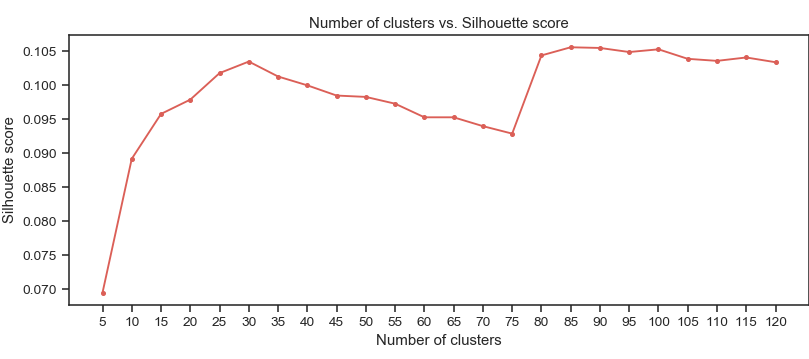

In [45]:
plt.figure(figsize=(9,4))

n_clusters = rough_n_k_cat
sil_scores = rough_scores_cat

plt.plot(n_clusters, sil_scores, '.-')
plt.xticks(n_clusters)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.title('Number of clusters vs. Silhouette score')

plt.subplots_adjust(left=0.085, right=0.999, bottom=0.15, top=0.9)
plt.show()

The peaks are on aroung K = 30 and 85.  
First, I would like to divid the data into about 10 categories (call them big_categories). Second each of the big_categories will be devided into subcategories (call them medium_categories). Then, each of the medium_categories will be devided into smaller subcategories (call them mini_categories). From the plot above, let me say:  
  
the total number of big_categories : about 10  
the total number of medium_categories: about 30  
the total number of mini_categories: about 85 

In [91]:
# Decide the number of big_categories
big_n_k_cat, big_scores_cat  = aggclus_ca_silhouette_score(5, 15, 1, np_normalized_bow_cat_removed)

<IPython.core.display.Javascript object>


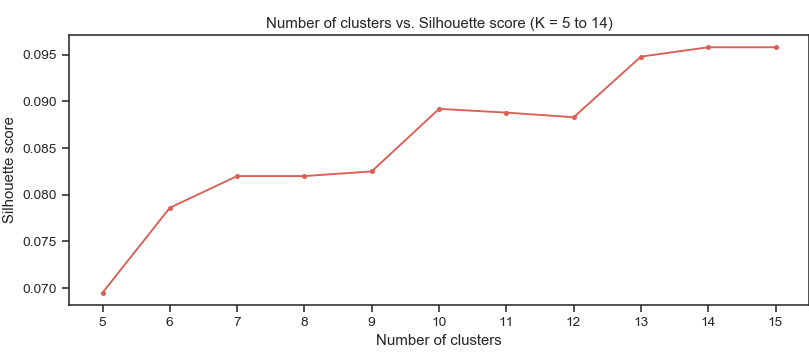

In [92]:
plt.figure(figsize=(9,4))

n_clusters = big_n_k_cat
sil_scores = big_scores_cat

plt.plot(n_clusters, sil_scores, '.-')
plt.xticks(n_clusters)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.title('Number of clusters vs. Silhouette score (K = 5 to 14)')

plt.subplots_adjust(left=0.085, right=0.999, bottom=0.15, top=0.9)
plt.show()

K = 10 for big_categories

In [ ]:
# Decide the number of medium_categories
medium_n_k_cat, medium_scores_cat  = aggclus_ca_silhouette_score(25, 35, 1, np_normalized_bow_cat_removed)

In [ ]:
plt.figure(figsize=(9,4))

n_clusters = medium_n_k_cat
sil_scores = medium_scores_cat

plt.plot(n_clusters, sil_scores, '.-')
plt.xticks(n_clusters)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.title('Number of clusters vs. Silhouette score (K = 25 to 35)')

plt.subplots_adjust(left=0.085, right=0.999, bottom=0.15, top=0.9)
plt.show()

K = 29 for medium_categories

In [ ]:
# Decide the number of mini_categories
mini_n_k_cat, mini_scores_cat  = aggclus_ca_silhouette_score(80, 90, 1, np_normalized_bow_cat_removed)

In [ ]:
plt.figure(figsize=(9,4))

n_clusters = mini_n_k_cat
sil_scores = mini_scores_cat

plt.plot(n_clusters, sil_scores, '.-')
plt.xticks(n_clusters)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.title('Number of clusters vs. Silhouette score (K = 85 to 95)')

plt.subplots_adjust(left=0.085, right=0.999, bottom=0.15, top=0.9)
plt.show()

K = 84 for mini_categories

In [47]:
# Agglomerative clustering (n_clusters=10, big_categories)
n_clusters=10

model_cat_10 = AgglomerativeClustering(n_clusters=n_clusters, affinity='cosine', linkage='average')
model_cat_10 = model_cat_10.fit(np_normalized_bow_cat_removed)

In [142]:
@interact(mode=['all', 'Cluster_0', 'Cluster_1', 'Cluster_2', 'Cluster_3', 'Cluster_4', 
                'Cluster_5', 'Cluster_6', 'Cluster_7', 'Cluster_8', 'Cluster_9'])
def interactive_plot(mode):
    if mode == 'all':
        plt.figure(figsize=(9,7))
        model = model_cat_10
        tsne_features = tsne_features_cat_removed

        for i in range(model.n_clusters_):
            plt.scatter(tsne_features[model.labels_ == i][:,0], 
                        tsne_features[model.labels_ == i][:,1], 
                        s=4, alpha=0.8, c=[cmap1(i/model.n_clusters_)], label=i)   
            plt.text(tsne_features[model.labels_ == i][:,0][0],
                     tsne_features[model.labels_ == i][:,1][0],
                     str(i), color="black", size=16)
    else:
        number = int(mode[8])
        cluster_plot(tsne_features_cat_divided, number, df_label_cat, 'label_10', 'label_10')
    
    plt.legend(loc='lower center', bbox_to_anchor=(.5, 1), ncol=10)
    plt.subplots_adjust(left=0.035, right=0.999, bottom=0.04, top=0.85)
    plt.xlim(-45, 55)
    plt.ylim(-50, 55)
    plt.show()

interactive(children=(Dropdown(description='mode', options=('all', 'Cluster_0', 'Cluster_1', 'Cluster_2', 'Clu…

<IPython.core.display.Javascript object>


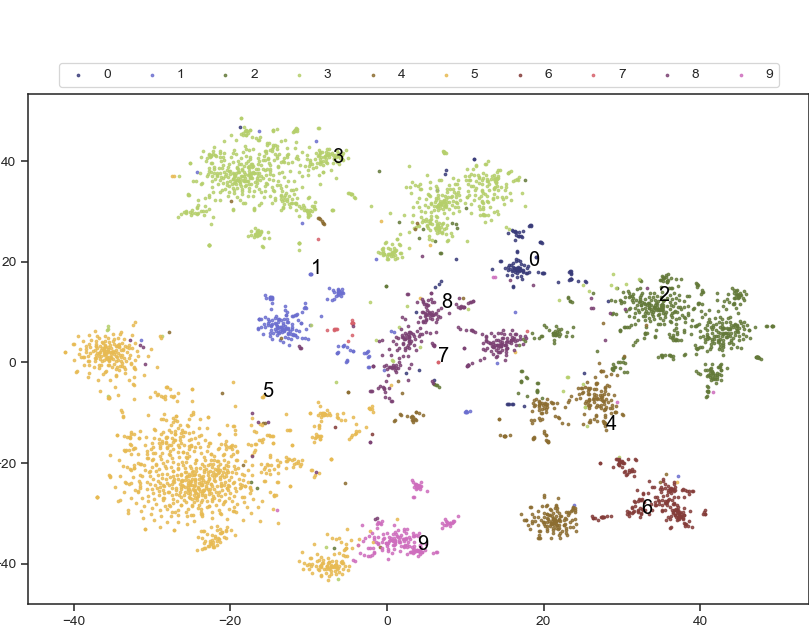

In [56]:
# Scatter plot, colored by the labels
plt.figure(figsize=(9,7))

model = model_cat_10
tsne_features = tsne_features_cat_removed

for i in range(model.n_clusters_):
    plt.scatter(tsne_features[model.labels_ == i][:,0], 
                tsne_features[model.labels_ == i][:,1], 
                s=4, alpha=0.8, c=[cmap1(i/model.n_clusters_)], label=i)   
    plt.text(tsne_features[model.labels_ == i][:,0][0],
             tsne_features[model.labels_ == i][:,1][0],
             str(i), color="black", size=16
             )
        
plt.legend(loc='lower center', bbox_to_anchor=(.5, 1), ncol=10)
plt.subplots_adjust(left=0.035, right=0.999, bottom=0.04, top=0.85)
# plt.xlim(-55, 55)
# plt.ylim(-50, 50)
plt.show()

<IPython.core.display.Javascript object>


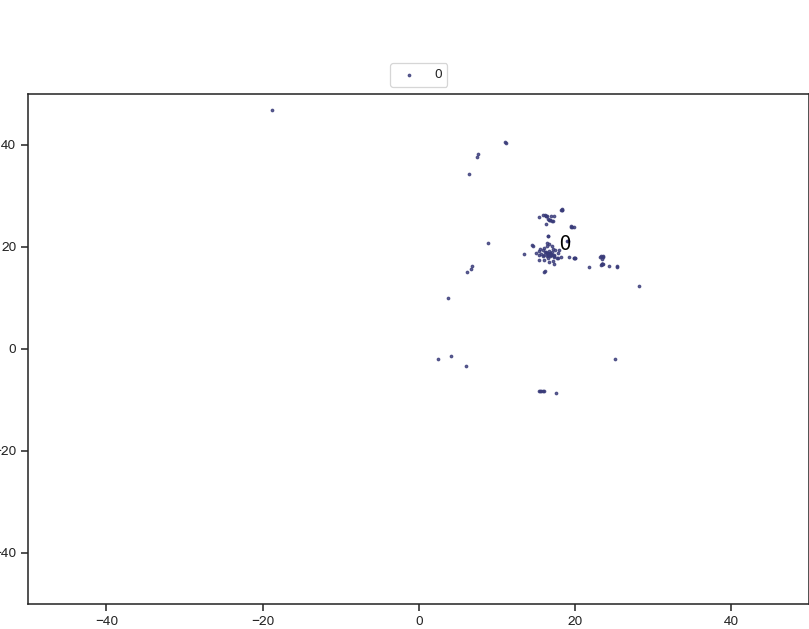

In [75]:
# Scatter plot, colored by the labels
plt.figure(figsize=(9,7))

model = model_cat_10
tsne_features = tsne_features_cat_removed

for i in [0]:
    plt.scatter(tsne_features[model.labels_ == i][:,0], 
                tsne_features[model.labels_ == i][:,1], 
                s=4, alpha=0.8, c=[cmap1(i/model.n_clusters_)], label=i)   
    plt.text(tsne_features[model.labels_ == i][:,0][0],
             tsne_features[model.labels_ == i][:,1][0],
             str(i), color="black", size=16
             )
        
plt.legend(loc='lower center', bbox_to_anchor=(.5, 1), ncol=10)
plt.subplots_adjust(left=0.035, right=0.999, bottom=0.04, top=0.85)
plt.xlim(-50, 50)
plt.ylim(-50, 50)
plt.show()

<IPython.core.display.Javascript object>


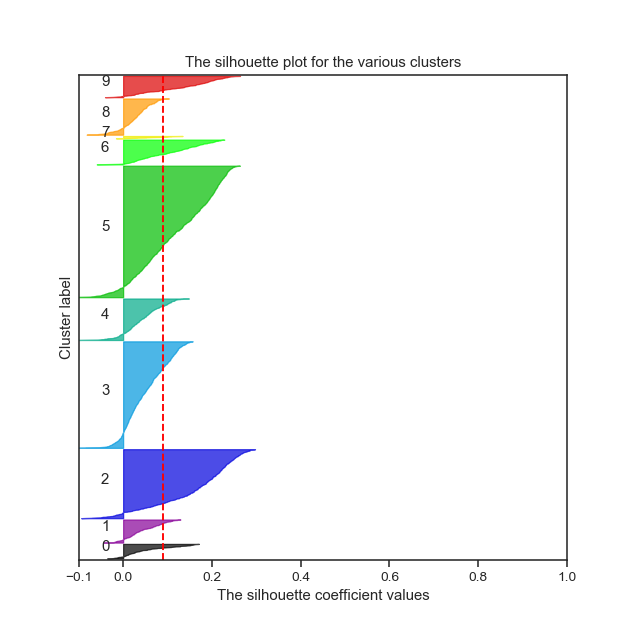

For n_clusters = 10 , The average silhouette_score is : 0.08916626430942257


In [57]:
silhouette(model_cat_10.n_clusters_, model_cat_10.labels_, np_normalized_bow_cat_removed)

In [59]:
df_label_cat = df_cat_id_name_removed[['product_id', 'product_title']]
df_label_cat['label_10'] = model_cat_10.labels_

In [60]:
frequent_words(df_label_cat, 'label_10')

,frequent words,number of products
cluster number,,
0,"(door, dog, window, room, box, fit, lock, sturdi, instruct, flap)",122
1,"(collar, fit, color, bell, dog, neck, comfort, materi, tag, design)",192
2,"(litter, box, smell, scoop, odor, clump, bag, floor, room, stuff)",573
3,"(play, toy, scratch, interest, fun, sturdi, box, catnip, room, post)",884
4,"(dog, smell, stuff, spray, flea, carpet, spot, odor, bottl, stain)",345
5,"(food, eat, dri, feed, treat, dog, flavor, stuff, sinc, vet)",1091
6,"(hair, dog, brush, groom, coat, fur, comb, tool, hand, cut)",206
7,"(beauti, rest, belov, custom, dog, design, color, fit, engrav, stone)",20
8,"(dog, comfort, carrier, bed, pad, room, fit, travel, wash, vet)",301


In [ ]:
# 

In [61]:
df_label_cat[df_label_cat['label_10'] == 5].sample(20)

,product_id,product_title,label_10
1,593896.0,Pet Food Can Covers Lids Set of 3Pet Food Can Covers Lids Set of 3Pet Food Can Covers Lids Set o...,5
2,919291.0,Basis Pet Made in the USA Low Profile Stainless Steel Cat DishBasis Pet Made in the USA Low Prof...,5
3,944764.0,Alfie Pet by Petoga Couture - Vea 2.0 Slow-Eating Anti-Gulping Pet Food Bowl (for Dogs & Cats)Al...,5
6,1439965.0,Hill's Science Diet Sensitive Stomach and Skin Dry Cat FoodHill's Science Diet Sensitive Stomach...,5
7,1457386.0,Grain Free Chicken Cat FoodGrain Free Chicken Cat FoodGrain Free Chicken Cat FoodGrain Free Chic...,5
...,...,...,...
3924,996379228.0,IAMS PROACTIVE HEALTH Mature Adult Dry Cat FoodIAMS PROACTIVE HEALTH Mature Adult Dry Cat FoodIA...,5
3926,997258613.0,"Blue Buffalo Longevity Dry Food for Mature Cats, 5-PoundBlue Buffalo Longevity Dry Food for Matu...",5
3930,999135471.0,NaturVet Naturals Dog & Cat Allergy Aid Soft ChewsNvet Aller-911 Sft Chew 90ctNaturVet Naturals ...,5
3931,999281618.0,Nature's Variety Pride by Instinct Grain Free Dry Cat FoodNature's Variety Pride by Instinct Gra...,5


Medium_categories

In [62]:
# Agglomerative clustering (n_clusters=29, medium_categories)
n_clusters=29

model_cat_29 = AgglomerativeClustering(n_clusters=n_clusters, affinity='cosine', linkage='average')
model_cat_29 = model_cat_29.fit(np_normalized_bow_cat_removed)

<IPython.core.display.Javascript object>


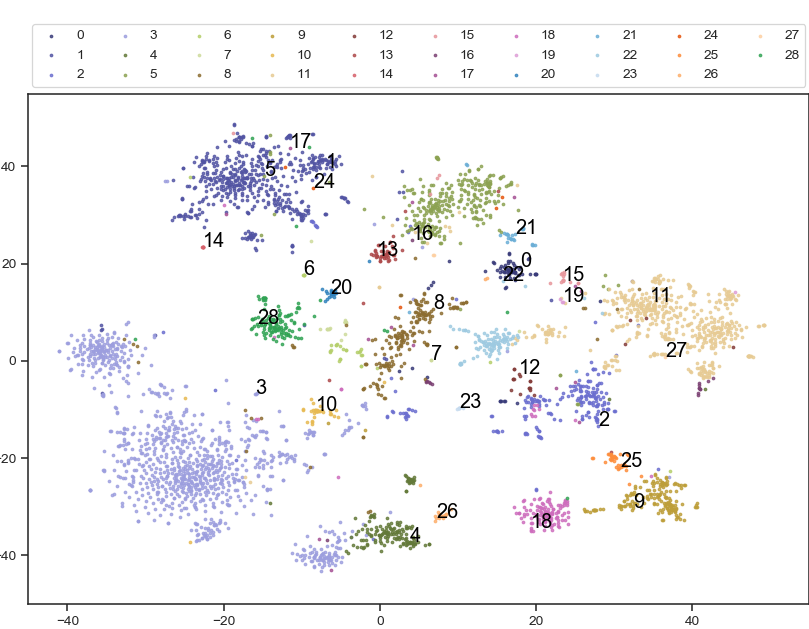

In [83]:
# Scatter plot, coloring by variety_numbers
plt.figure(figsize=(9,7))

model = model_cat_29
tsne_features = tsne_features_cat_removed

for i in range(model.n_clusters_):
# for i in range(model.n_clusters_):
    plt.scatter(tsne_features[model.labels_ == i][:,0], 
                tsne_features[model.labels_ == i][:,1], 
                s=4, alpha=0.8, c=[cmaps[i]], label=i)   
    plt.text(tsne_features[model.labels_ == i][:,0][0],
             tsne_features[model.labels_ == i][:,1][0],
             str(i), color="black", size=16)
        
plt.legend(loc='lower center', bbox_to_anchor=(.5, 1), ncol=10)
plt.subplots_adjust(left=0.035, right=0.999, bottom=0.04, top=0.85)
plt.xlim(-45, 55)
plt.ylim(-50, 55)
plt.show()

<IPython.core.display.Javascript object>


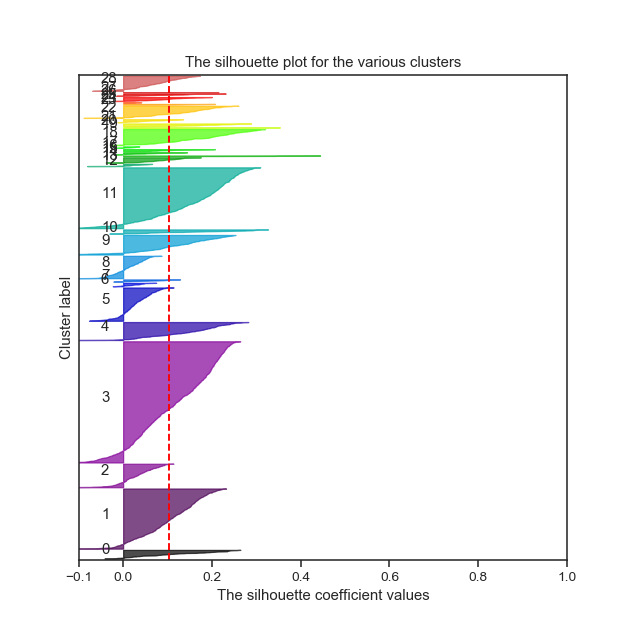

For n_clusters = 29 , The average silhouette_score is : 0.10378199694781891


In [67]:
silhouette(model_cat_29.n_clusters_, model_cat_29.labels_, np_normalized_bow_cat_removed)

In [68]:
df_label_cat['label_29'] = model_cat_29.labels_

In [95]:
# Get the t-SNE features of each big_category
tsne_features_cat_divided = []
for k in range(10):
    indexes = df_label_cat[df_label_cat['label_10'] == k].index
    features = []
    for i in range(len(tsne_features_cat)):
        if i in indexes:
            features.append(tsne_features_cat[i])
    tsne_features_cat_divided.append(np.array(features))
    
len(tsne_features_cat_divided)

10

In [71]:
n_clusters = df_label_cat['label_29'].nunique()
df_29cluster = pd.DataFrame(columns=['big_category_number', 'medium_category_number','frequent words', 'number of products'])
for i in range(n_clusters):
    words = []
    indexes = df_label_cat[df_label_cat['label_29'] == i].index
    big_category_number = df_label_cat[df_label_cat['label_29'] == i].iat[0, 2]
    for index in indexes:
        for word in set(new_cat_token_list[index]):
            words.append(word)
    c = Counter(words)
    values, _ = zip(*c.most_common(10))

    df_temp = pd.DataFrame([[big_category_number, i, values, len(indexes)]], 
                                columns=df_29cluster.columns)
    df_29cluster = df_29cluster.append(df_temp) 

df_29cluster.set_index(['big_category_number']).sort_index()

,medium_category_number,frequent words,number of products
big_category_number,,,
0,0,"(door, dog, lock, flap, room, fit, box, instruct, window, hole)",76
0,21,"(window, wall, sturdi, perch, jump, sill, wood, shelf, frame, room)",27
0,15,"(cage, hammock, room, box, door, sturdi, space, bottom, fit, water)",19
1,23,"(cone, comfort, plastic, recoveri, box, shame, neck, fit, design, tube)",6
1,20,"(har, leash, fit, walk, dog, comfort, color, strap, neck, clip)",25
1,6,"(fit, dog, color, velcro, medium, tie, ador, strap, dress, photo)",30
1,28,"(collar, bell, color, fit, neck, dog, tag, materi, scratch, design)",131
2,19,"(sand, box, tank, bag, cage, water, sandi, hermit, crab, litter)",4
2,11,"(litter, box, smell, scoop, odor, clump, bag, floor, mess, plastic)",529


In [96]:
df_label_cat[df_label_cat['label_29'] == 0].sample(20)

,product_id,product_title,label_10,label_29,label_84
3390,866790010.0,Tattle Tale Sonic Pet Training AlarmTattle Tale Sonic Pet Training AlarmVibration Pet Trainer/Al...,0,0,41
1873,478448166.0,Contech StayAway Motion-Activated Pet DeterrentContech StayAway Motion-Activated Pet DeterrentCo...,0,0,41
3218,822117487.0,"Best Choice Products Raccoon Skunk Poss Humane Animal Trap 31""x12""x12"" Cage Rabbit Cat LiveBest ...",0,0,26
0,70064.0,Perfect Pet Soft Flap Cat Door with Telescoping FramePerfect Pet Soft Flap Cat Door with Telesco...,0,0,26
1237,319470804.0,Cat Door - The Original Cathole Interior Pet Door - The Only Cat Door With A Cleaning / Grooming...,0,0,26
399,107233212.0,Cat Homes and Eclosures Product VariationCat Homes and Eclosures Product VariationCat Homes and ...,0,0,29
1959,501512391.0,"Van Ness CP7 Enclosed Cat Pan/Litter Box, Extra LargeVan Ness CP7 Enclosed Cat Pan/Litter Box, E...",0,0,26
3204,817515257.0,PetSafe 4-Way Locking Cat FlapPetSafe 4-Way Locking Cat FlapPetSafe 4-Way Locking Cat FlapPetSaf...,0,0,26
254,66001267.0,PetSafe Pet Screen DoorPetSafe Pet Screen DoorPetSafe Pet Screen DoorPetSafe Pet Screen DoorPetS...,0,0,26
516,137012216.0,Tomcat Live Catch Mouse Trap Multiple Mouse SizeTomcat Live Catch Mouse Trap Multiple Mouse Size...,0,0,26


In [135]:
from ipywidgets import interact

@interact(mode=['Cluster_0', 'Cluster_1', 'Cluster_2', 'Cluster_3', 'Cluster_4', 
                'Cluster_5', 'Cluster_6', 'Cluster_7', 'Cluster_8', 'Cluster_9'])
def interactive_plot(mode):
    number = int(mode[8])
    tsne_features = tsne_features_cat_divided[number]
    df_cluster = df_label_cat[df_label_cat['label_10'] == number].sort_index()
    
    plt.figure(figsize=(9,7))
    for i in df_cluster['label_29'].unique():
        bool_array = (df_cluster['label_29'] == i).values
        plt.scatter(tsne_features[bool_array][:,0], 
                    tsne_features[bool_array][:,1], 
                    s=4, alpha=0.8, c=[cmaps[i]], label=i)   
        plt.text(tsne_features[bool_array][:,0][0],
                 tsne_features[bool_array][:,1][0],
                 str(i), color="black", size=16)
        
    plt.legend(loc='lower center', bbox_to_anchor=(.5, 1), ncol=10)
    plt.subplots_adjust(left=0.035, right=0.999, bottom=0.04, top=0.85)
    plt.xlim(-45, 55)
    plt.ylim(-50, 55)
    plt.show()

interactive(children=(Dropdown(description='mode', options=('Cluster_0', 'Cluster_1', 'Cluster_2', 'Cluster_3'…

In [134]:
@interact(mode=['Cluster_0', 'Cluster_1', 'Cluster_2', 'Cluster_3', 'Cluster_4', 
                'Cluster_5', 'Cluster_6', 'Cluster_7', 'Cluster_8', 'Cluster_9'])
def interactive_plot(mode):
    number = int(mode[8])
    cluster_plot(tsne_features_cat_divided, number, df_label_cat, 'label_10', 'label_29')
    
    plt.legend(loc='lower center', bbox_to_anchor=(.5, 1), ncol=10)
    plt.subplots_adjust(left=0.035, right=0.999, bottom=0.04, top=0.85)
    plt.xlim(-45, 55)
    plt.ylim(-50, 55)
    plt.show()

interactive(children=(Dropdown(description='mode', options=('Cluster_0', 'Cluster_1', 'Cluster_2', 'Cluster_3'…

In [126]:
# Scatter plot, coloring by variety_numbers
def cluster_plot(tsne_features, cluster_n, df, cluster_n_column, label_column):
    '''
    Plot the t-SNE image for a big_category cluster with the selected labels
    '''
    plt.figure(figsize=(9,7))

    df_cluster = df[df[cluster_n_column] == cluster_n].sort_index()

    for i in df_cluster[label_column].unique():
        bool_array = (df_cluster[label_column] == i).values
        plt.scatter(tsne_features[cluster_n][bool_array][:,0], 
                    tsne_features[cluster_n][bool_array][:,1], 
                    s=4, alpha=0.8, c=[cmaps[i]], label=i)   
        plt.text(tsne_features[cluster_n][bool_array][:,0][0],
                 tsne_features[cluster_n][bool_array][:,1][0],
                 str(i), color="black", size=16)

<IPython.core.display.Javascript object>


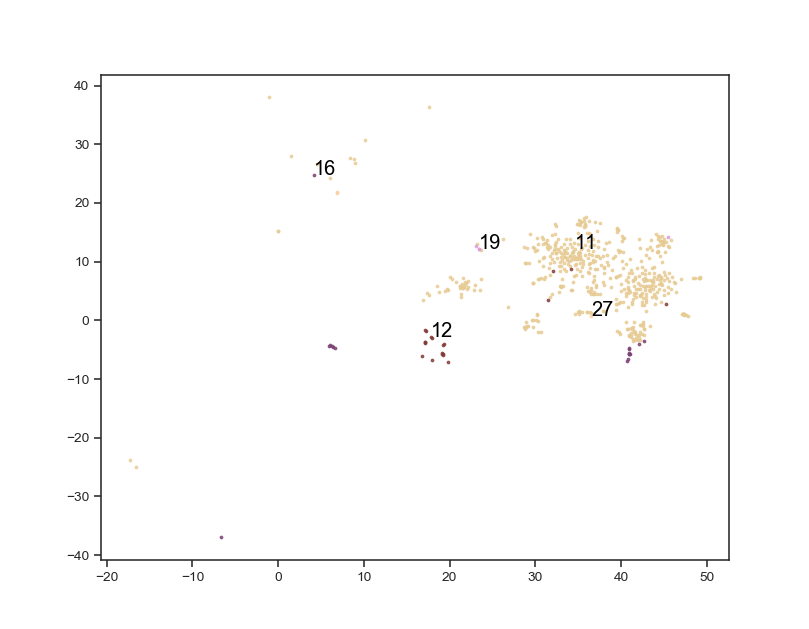

In [130]:
cluster_plot(tsne_features_cat_divided, 2, df_label_cat, 'label_10', 'label_29')

<IPython.core.display.Javascript object>


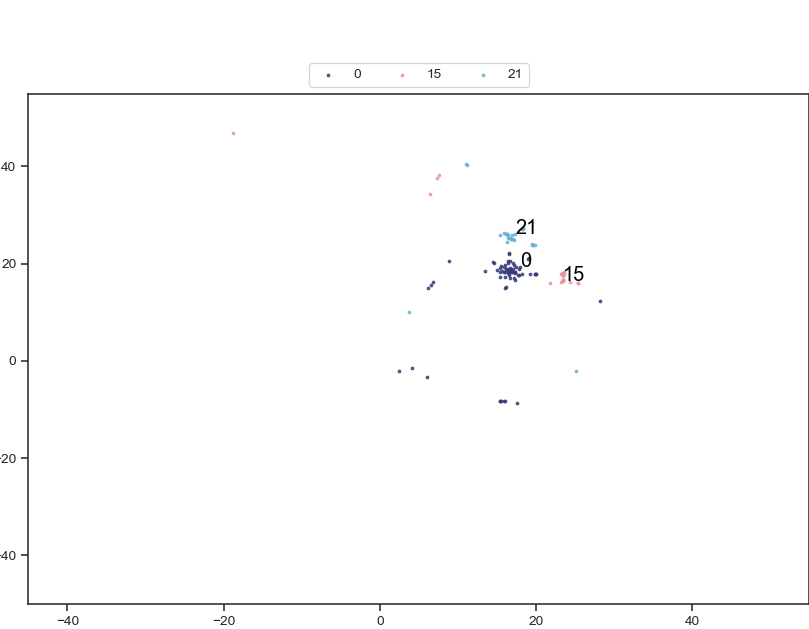

In [119]:
# Scatter plot, coloring by variety_numbers
plt.figure(figsize=(9,7))

tsne_features = tsne_features_cat_divided[0]
df_cluster0 = df_label_cat[df_label_cat['label_10'] == 0].sort_index()

for i in df_cluster0['label_29'].unique():
    bool_array = (df_cluster0['label_29'] == i).values
    plt.scatter(tsne_features[bool_array][:,0], 
                tsne_features[bool_array][:,1], 
                s=4, alpha=0.8, c=[cmaps[i]], label=i)   
    plt.text(tsne_features[bool_array][:,0][0],
             tsne_features[bool_array][:,1][0],
             str(i), color="black", size=16)
        
plt.legend(loc='lower center', bbox_to_anchor=(.5, 1), ncol=10)
plt.subplots_adjust(left=0.035, right=0.999, bottom=0.04, top=0.85)
plt.xlim(-45, 55)
plt.ylim(-50, 55)
plt.show()

In [118]:
df_cluster0['label_29'].unique()

array([ 0, 15, 21], dtype=int64)

<IPython.core.display.Javascript object>


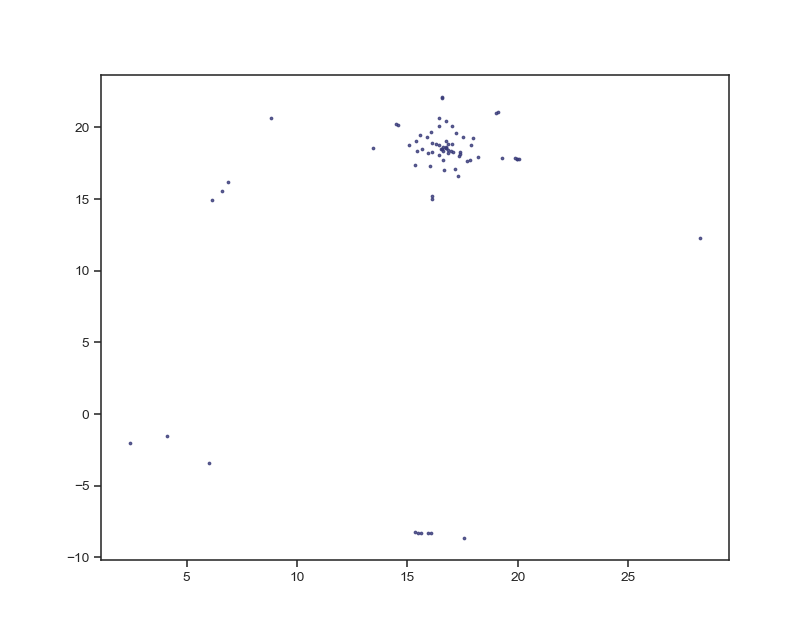

In [117]:
plt.figure(figsize=(9,7))

bool_array = (df_cluster0['label_29'] == 0).values
plt.scatter(tsne_features_cat_divided[0][bool_array][:,0], 
            tsne_features_cat_divided[0][bool_array][:,1], 
            s=4, alpha=0.8, c=[cmaps[0]])  


In [102]:
len(tsne_features_cat_divided[0])

122

In [107]:
len(tsne_features)

122

In [116]:
len(model_cat_29.labels_ == 0)

3911

In [114]:
(df_cluster0['label_29'] == 0).values

array([ True,  True,  True, False, False, False, False,  True, False,
       False,  True,  True,  True,  True,  True, False,  True, False,
        True,  True,  True,  True, False,  True,  True, False, False,
       False,  True,  True, False,  True,  True,  True, False,  True,
       False,  True,  True,  True,  True,  True,  True, False,  True,
        True,  True,  True, False,  True, False, False, False, False,
        True,  True,  True,  True,  True, False,  True,  True, False,
        True, False,  True, False,  True, False,  True,  True,  True,
       False, False,  True, False, False,  True,  True,  True,  True,
        True,  True,  True, False, False,  True, False,  True, False,
       False,  True, False, False,  True,  True, False, False, False,
        True,  True,  True,  True,  True, False, False, False,  True,
        True, False,  True,  True, False,  True,  True,  True,  True,
        True, False,  True,  True,  True])

In [ ]:
# Scatter plot, coloring by variety_numbers
plt.figure(figsize=(9,7))

model = model_cat_29
tsne_features = tsne_features_cat_removed

for i in range(model.n_clusters_):
# for i in range(model.n_clusters_):
    plt.scatter(tsne_features[model.labels_ == i][:,0], 
                tsne_features[model.labels_ == i][:,1], 
                s=4, alpha=0.8, c=[cmaps[i]], label=i)   
    plt.text(tsne_features[model.labels_ == i][:,0][0],
             tsne_features[model.labels_ == i][:,1][0],
             str(i), color="black", size=16)
        
plt.legend(loc='lower center', bbox_to_anchor=(.5, 1), ncol=10)
plt.subplots_adjust(left=0.035, right=0.999, bottom=0.04, top=0.85)
plt.xlim(-45, 55)
plt.ylim(-50, 55)
plt.show()

In [86]:
df_label_cat[df_label_cat['label_10'] == 0].index

Int64Index([   0,   43,   63,  140,  154,  211,  236,  238,  247,  249,
            ...
            3452, 3545, 3598, 3632, 3652, 3657, 3819, 3828, 3831, 3884],
           dtype='int64', length=122)

In [76]:
# Agglomerative clustering (n_clusters=84, mini_categories)
n_clusters=84

model_cat_84 = AgglomerativeClustering(n_clusters=n_clusters, affinity='cosine', linkage='average')
model_cat_84 = model_cat_84.fit(np_normalized_bow_cat_removed)

<IPython.core.display.Javascript object>


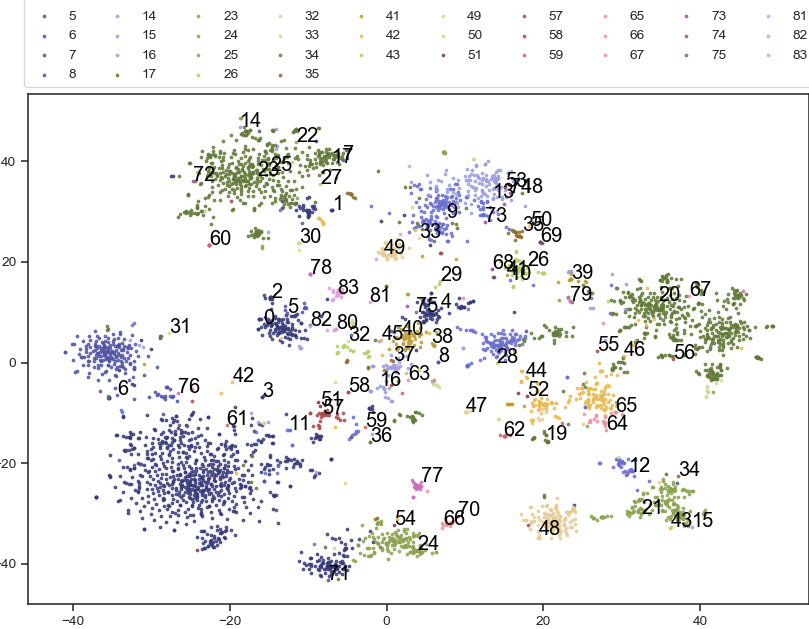

In [189]:
# Scatter plot, coloring by variety_numbers
plt.figure(figsize=(9,7))

model = model_cat_84
tsne_features = tsne_features_cat_removed

for i in range(model.n_clusters_):
# for i in range(model.n_clusters_):
    plt.scatter(tsne_features[model.labels_ == i][:,0], 
                tsne_features[model.labels_ == i][:,1], 
                s=4, alpha=0.8, c=[cmap1(i/model.n_clusters_)], label=i)   
    plt.text(tsne_features[model.labels_ == i][:,0][0],
             tsne_features[model.labels_ == i][:,1][0],
             str(i), color="black", size=16
             )
        
plt.legend(loc='lower center', bbox_to_anchor=(.5, 1), ncol=10)
plt.subplots_adjust(left=0.035, right=0.999, bottom=0.04, top=0.85)
# plt.xlim(-55, 55)
# plt.ylim(-50, 50)
plt.show()

<IPython.core.display.Javascript object>


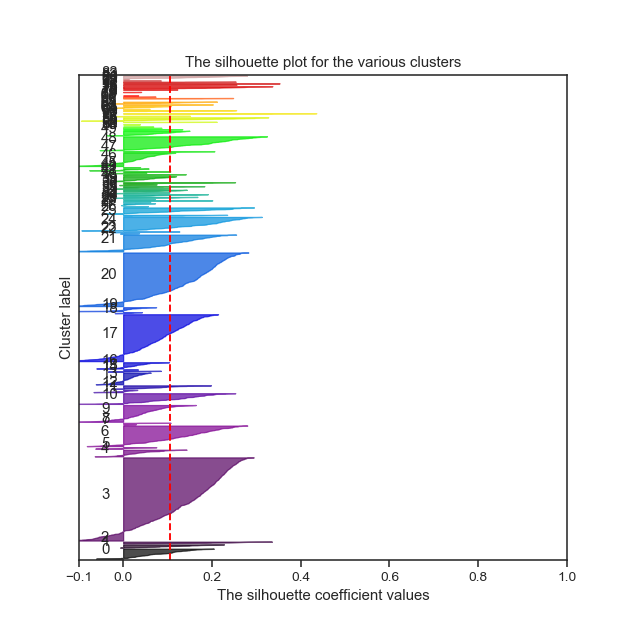

For n_clusters = 84 , The average silhouette_score is : 0.10577686823768606


In [77]:
silhouette(model_cat_84.n_clusters_, model_cat_84.labels_, np_normalized_bow_cat_removed)

In [78]:
df_label_cat['label_84'] = model_cat_84.labels_

In [79]:
n_clusters = df_label_cat['label_84'].nunique()
df_84cluster = pd.DataFrame(columns=['big_category_number', 'medium_category_number', 'small_category_number',
                                   'frequent words', 'number of products'])
for i in range(n_clusters):
    words = []
    indexes = df_label_cat[df_label_cat['label_84'] == i].index
    big_category_number = df_label_cat[df_label_cat['label_84'] == i].iat[0, 2]
    medium_category_number = df_label_cat[df_label_cat['label_84'] == i].iat[0, 3]
    
    for index in indexes:
        for word in set(new_cat_token_list[index]):
            words.append(word)
    c = Counter(words)
    values, _ = zip(*c.most_common(10))

    df_temp = pd.DataFrame([[big_category_number, medium_category_number, i, values, len(indexes)]], 
                                columns=df_84cluster.columns)
    df_84cluster = df_84cluster.append(df_temp) 

df_84cluster.set_index(['big_category_number', 'medium_category_number']).sort_index()

small_category_number  \
big_category_number medium_category_number                         
0                   0                                         26   
                    0                                         29   
                    0                                         41   
                    0                                         68   
                    15                                        14   
...                                                          ...   
9                   4                                         24   
                    4                                         54   
                    4                                         77   
                    26                                        66   
                    26                                        70   

                                                                                                               frequent words  \
big_category_number medium_category_number                                                                                      
0                   0                                         (door, dog, flap, lock, box, fit, room, instruct, window, push)   
                    0                             (sturdi, roof, packag, fix, enjoy, cedar, perch, rain, craftsmanship, door)   
                    0                                    (counter, kitchen, spray, tabl, jump, tape, deter, door, quick, dog)   
                    0                       (creat, guess, leather, deck, outsid, voluntarili, sunni, attach, canopi, custom)   
                    15                                  (hammock, hang, cage, durabl, post, fit, tower, fabric, corner, sinc)   
...                                                                                                                       ...   
9                   4                                    (water, fountain, filter, bowl, drink, dog, pump, motor, food, fill)   
                    4                                   (sister, brother, see, water, sinc, enter, rain, didnt, plastic, law)   
                    4                                    (grass, seed, grow, plant, eat, water, stuff, sprout, instruct, pot)   
                    26                           (tank, gallon, aquarium, water, top, packag, shrimp, light, fit, marineland)   
                    26                                   (lock, design, tank, stuff, pull, sturdi, surpris, grab, fit, today)   

                                           number of products  
big_category_number medium_category_number                     
0                   0                                      63  
                    0                                       3  
                    0                                       9  
                    0                                       1  
                    15                                      8  
...                                                       ...  
9                   4                                     133  
                    4                                       2  
                    4                                      22  
                    26                                     17  
                    26                                      3  

[84 rows x 3 columns]

In [80]:
df_label_cat[df_label_cat['label_84'] == 1].sample(20)

,product_id,product_title,label_10,label_29,label_84
2566,665086126.0,Yeowww! Catnip Pillows Yellow (Single)Yeowww! Catnip Pillows Yellow (Single)Yeowww! Catnip Pillo...,3,1,1
1341,340477678.0,"Handmade in the USA Catnip Kickers (choice of boy or girl patterns, 1 kicker per order)Handmade ...",3,1,1
1808,461361743.0,Sentry HC Groom'n Comb/with Catnip PouchSentry HC Groom'n Comb/with Catnip PouchSentry HC Groom'...,3,1,1
281,73740699.0,OurPets Premium North- American Grown Cosmic CatnipOurPets Premium North- American Grown Cosmic ...,3,1,1
1141,296339375.0,Petlinks Compressed Catnip Cat ToysPetlinks Compressed Catnip Cat ToysPetlinks Compressed Catnip...,3,1,1
3775,958506170.0,PetGuard Catnip 100% Organic -- 1.5 ozPetGuard Catnip 100% Organic -- 1.5 ozPetGuard Catnip 100%...,3,1,1
204,51834450.0,Lambert Kay Mr. Spats Cat-A-Comb Self Grooming Cat BrushLambert Kay Mr. Spats Cat-A-Comb Self Gr...,3,1,1
3308,846958823.0,"Yeowww Catnip Bags, 1-OunceYeowww Catnip Bags, 1-OunceYeowww Catnip Bags, 1-OunceYeowww Catnip B...",3,1,1
26,5287233.0,Catit Self Groomer with CatnipCatit Self Groomer with CatnipCatit Self Groomer with CatnipCatit ...,3,1,1
1190,308040880.0,Catnip in a CupCatnip in a CupCosmic Pet 808091 Cosmic Catnip Cup 2.25 Oz.Catnip in a CupCatnip ...,3,1,1
